Members:
- Kiamehr Javid: 2084294
- Jelin Raphael Akkara: 2072064
- Davide Checchia: 2078232

## Libraries, Constants, Pre-processing pipelines

In [2]:
import numpy as np
import librosa
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler
from keras import layers, ops
import os
import matplotlib.pyplot as plt
import pickle
from numba import cuda
import sounddevice as sd
import IPython
from IPython.display import display, Audio
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, Delaunay
from matplotlib import cm
import matplotlib.colors as mcolors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.io.wavfile import write
from scipy.signal import wiener
from scipy.signal import medfilt



In [3]:
# Constants
SAMPLE_RATE = 16000
N_FFT = 2048
FRAME_SIZE = 448
HOP_LENGTH = 167
N_MELS = 64
latent_dim = 16


labels = ["yes", "stop", "down", "right", "no", "left", "up", "go"]

allowed_words = labels[0:]

tab10 = plt.cm.get_cmap('tab10', 8)
colors = tab10.colors[:len(allowed_words)]
cmap = mcolors.ListedColormap(colors)



/tmp/ipykernel_94088/3869547351.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = plt.cm.get_cmap('tab10', 8)


#### functions/utils

In [4]:
def pad(arr, mlen = SAMPLE_RATE, noise_amp = 0., only_pad = False):
    if len(arr) >= mlen: return arr
    else:
        padded = np.random.normal(loc = 0.0001, scale = noise_amp, size = mlen)
        start = (mlen - len(arr))//2
        if only_pad: padded[start:start+len(arr)] = arr
        else: padded[start:start+len(arr)] += arr
        return padded

def pre_pipe(wav, SAMPLE_RATE = SAMPLE_RATE, FRAME_SIZE = FRAME_SIZE, HOP_LENGTH = HOP_LENGTH, N_MELS = N_MELS, N_FFT = N_FFT):

    wav /= np.max(np.abs(wav))
    wav = pad(wav)
    spectrogram = librosa.feature.melspectrogram(y = wav, sr=SAMPLE_RATE, win_length=FRAME_SIZE, n_fft = N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    return log_spectrogram




def pipe_inv(out, train_max = 1, train_min = 0, SAMPLE_RATE = SAMPLE_RATE, FRAME_SIZE = FRAME_SIZE, N_FFT = N_FFT, HOP_LENGTH = HOP_LENGTH, N_MELS = N_MELS):

    out = out.reshape(out.shape[0], out.shape[1])
    db = out * (train_max - train_min) + train_min
    amp = librosa.db_to_amplitude(db)
    wav = librosa.feature.inverse.mel_to_audio(amp, sr=SAMPLE_RATE, win_length=FRAME_SIZE, n_fft = N_FFT, hop_length=HOP_LENGTH)
    wav = wav / np.max(np.abs(wav))
    return wav


def plot_PCA(ld, labs, n, labels = allowed_words, cmap = cmap, ldim = 3, path_PCA = '', path_EVR = ''):
    nw = len(labels)
    latent_data = ld.copy()
    pca = PCA(n_components=ldim)
    t2d = pca.fit_transform(pred)[:,:2]
    fig, ax = plt.subplots()
    ax.scatter(*t2d.T, c=labs, cmap=cmap)
    ax.set_title('PCA')
    fig.colorbar(ax=ax, ticks=np.linspace(0,1,nw+1)[:-1]+0.5/nw,format="%s", mappable=cm.ScalarMappable(cmap=cmap)).set_ticklabels(labels)
    if len(path_PCA):
        plt.savefig(path_PCA)
    plt.show()
    y = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(np.arange(ldim)+1, y)
    y[y<0.9] = 1
    x = np.argmin(y)+1
    plt.text(x*0.9, 0.5, str(x) + ' components', rotation=90, verticalalignment='center', color='black')
    plt.axvline(x = x, color='r', ls='dashed', label = '0.9 explained variance')
    plt.xlabel('number of axes')
    plt.ylabel('variability captured')
    plt.legend()
    if len(path_EVR):
        plt.savefig(path_EVR)
    plt.show()
    

def plot_tsne(ld, labs, n, labels = allowed_words, cmap = cmap, path = ''):
    nw = len(labels)
    latent_data = ld.copy()
    tsne = TSNE(n_components=2)
    latent_data = tsne.fit_transform(latent_data)
    latent_data = latent_data.reshape(n, 2)
    fig, ax = plt.subplots()
    ax.scatter(latent_data[:, 0], latent_data[:, 1], c=labs, cmap=cmap)
    ax.set_title('t-SNE')
    fig.colorbar(ax=ax, ticks=np.linspace(0,1,nw+1)[:-1]+0.5/nw,format="%s", mappable=cm.ScalarMappable(cmap=cmap)).set_ticklabels(labels)
    if len(path):
        plt.savefig(path)
    plt.show()


def clusters_look_good(eps, min_samples, data, labs, nlabels = len(allowed_words)):
    gc = 0
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    cl_labels = db.labels_
    if np.sort(np.histogram(cl_labels,bins = np.arange(len(set(cl_labels))+1)-1.5, density = True)[0])[-1] > 0.5:
            
        n_clusters = len(set(cl_labels)) - (1 if -1 in cl_labels else 0)
        if(n_clusters >= nlabels) and (n_clusters < 20):
            for cl in range(n_clusters):
                hist = np.histogram(labs[cl_labels == cl], bins = np.arange(nlabels + 1)-.5, density=True)[0]
                if (np.sort(hist)[-1] > 0.55):
                    gc += 1
            return gc, n_clusters
    return 0, 0

### loading, preprocessing and shuffling

In [5]:
log_spectrograms = []


audio_dirs = "../VAE/data/mini_speech_commands"
labs = []



# Read all audio files
for root, dirs, files in os.walk(audio_dirs):

    for i, file in enumerate(files):
        if file.endswith(".wav"):

            word = root.split("/")[-1] 

            if word not in allowed_words:
                continue

            file_path = os.path.join(root, file)
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE) 
            labs.append(word)
            
            log_spectrogram = pre_pipe(audio)
            # Append to list
            log_spectrograms.append(log_spectrogram)


train_data = np.array(log_spectrograms)
train_data = train_data[..., np.newaxis]

train_max, train_min = train_data.max(), train_data.min()
train_data = (train_data - train_min) / (train_max - train_min)


label2int = {label: i for i, label in enumerate(labels)}
int2label = {i: label for i, label in enumerate(labels)}
labs = np.array([label2int[wrd] for wrd in labs])
allowed_labs = [label2int[wrd] for wrd in allowed_words]

# shuffling the data

indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
labs = labs[indices]


n, fbands, twindow, _ = train_data.shape

#### Plot an example of mel_spectrogram!!

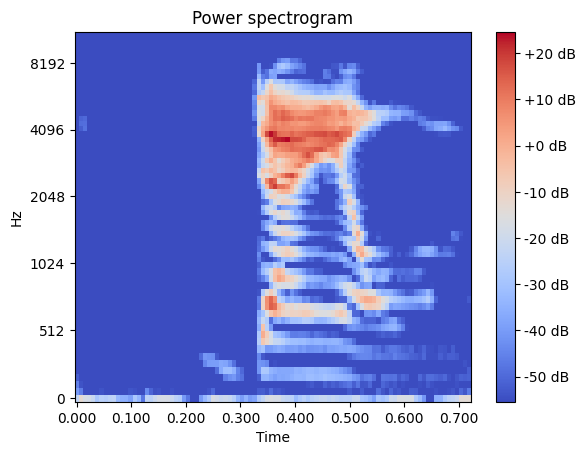

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(log_spectrograms[0],
                               y_axis='mel', x_axis='time', ax=ax, hop_length = HOP_LENGTH)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Architecture definition

In [7]:
keras.saving.get_custom_objects().clear()

@keras.saving.register_keras_serializable()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, seed_generator = keras.random.SeedGenerator(1337),**kwargs):
        super().__init__(**kwargs)
        self.seed_generator = seed_generator

    def get_config(self):
       base_config = super().get_config()
       return {
          **base_config,
          "seed_generator": keras.saving.serialize_keras_object(self.seed_generator)
       }

    @classmethod
    def from_config(cls, config):
        seed_generator_config = config.pop("seed_generator")
        seed_generator = keras.saving.deserialize_keras_object(seed_generator_config)
        return cls(seed_generator=seed_generator, **config)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

2024-07-18 20:16:00.558587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 20:16:00.631902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 20:16:00.635809: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
## Encoder!!

ldim = 16
def enc(input_shape = train_data.shape[1:], latent_dim = ldim, summ = False):
    
    input_shape = input_shape
    
    encoder_inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(128, 3, activation="gelu", padding="same")(encoder_inputs)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, 3, activation="gelu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, 3, activation="gelu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, 3, activation="gelu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    bottleneck_shape = ops.shape(x)[1:]
    x = layers.Flatten()(x)
    x = layers.Dropout(0.)(x)
    x = layers.Dense(2*latent_dim, activation ="gelu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    if summ:
        encoder.summary()
    return encoder, bottleneck_shape

encoder = enc()

In [9]:
## Decoder!!

def dec(latent_dim = ldim, bottleneck_shape = encoder[1], summ = False):
    decoder_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dropout(0.)(decoder_inputs)
    x = layers.Dense(np.prod(bottleneck_shape))(x)
    x = layers.Reshape(bottleneck_shape)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size = (2, 2))(x)
    x = layers.Conv2DTranspose(64, 3, activation="gelu", padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size = (2, 2))(x)
    x = layers.Conv2DTranspose(64, 3, activation="gelu", padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size = (2, 2))(x)
    x = layers.Conv2DTranspose(128, 3, activation="gelu", padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size = (2, 2))(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    if summ:
        decoder.summary()
    return decoder

decoder = dec()

In [10]:
# VAE_class, losses, me

@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, recloss, beta = float(1e2), **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.recloss = recloss
        self.beta = beta

    def get_config(self):
       base_config = super().get_config()
       return {
          **base_config,
          "encoder": keras.saving.serialize_keras_object(self.encoder),
          "decoder": keras.saving.serialize_keras_object(self.decoder),
          "recloss": keras.saving.serialize_keras_object(self.recloss),
          "beta": keras.saving.serialize_keras_object(self.beta)
          }

    @classmethod
    def from_config(cls, config):
        encoder_config = config.pop("encoder")
        encoder = keras.saving.deserialize_keras_object(encoder_config)
        decoder_config = config.pop("decoder")
        decoder = keras.saving.deserialize_keras_object(decoder_config)
        recloss_config = config.pop("recloss")
        recloss = keras.saving.deserialize_keras_object(recloss_config)
        beta_config = config.pop("beta")
        beta = keras.saving.deserialize_keras_object(beta_config)
        return cls(encoder, decoder, recloss, beta, **config)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            if self.recloss == 'mse':
              reconstruction_loss = ops.mean(ops.sum(tf.keras.losses.MSE(data, reconstruction), axis=(1, 2)))
            else:
              reconstruction_loss = ops.mean(ops.sum(keras.losses.binary_crossentropy(data, reconstruction),axis=(1, 2),))
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = self.beta*ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Training, Saving, Loading

In [11]:
nepoch = 40
lr = 1e-3
beta = 1e-3
BATCH_SIZE = [500]

in_shape = (train_data.shape[1:])

encoder = enc(input_shape = in_shape, latent_dim = 16)
decoder = dec(latent_dim = 16, bottleneck_shape = encoder[1])

vae = VAE(encoder[0], decoder, recloss = 'mse', beta = beta)

vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))


for batch_size in BATCH_SIZE:
        
    hist = vae.fit(train_data, epochs=nepoch, batch_size = batch_size, verbose=2)

534/534 - 7s - 13ms/step - kl_loss: 0.0931 - loss: 15.6692 - reconstruction_loss: 15.5761
Epoch 3/20
534/534 - 7s - 13ms/step - kl_loss: 0.0911 - loss: 13.8388 - reconstruction_loss: 13.7477
Epoch 4/20
534/534 - 7s - 13ms/step - kl_loss: 0.0883 - loss: 12.9616 - reconstruction_loss: 12.8732
Epoch 5/20
534/534 - 7s - 13ms/step - kl_loss: 0.0865 - loss: 12.2879 - reconstruction_loss: 12.2014
Epoch 6/20
534/534 - 7s - 13ms/step - kl_loss: 0.0830 - loss: 12.0500 - reconstruction_loss: 11.9670
Epoch 7/20
534/534 - 7s - 13ms/step - kl_loss: 0.0819 - loss: 11.7023 - reconstruction_loss: 11.6204
Epoch 8/20
534/534 - 7s - 13ms/step - kl_loss: 0.0807 - loss: 11.3835 - reconstruction_loss: 11.3028
Epoch 9/20
534/534 - 7s - 13ms/step - kl_loss: 0.0788 - loss: 11.0913 - reconstruction_loss: 11.0125
Epoch 10/20
534/534 - 7s - 13ms/step - kl_loss: 0.0784 - loss: 10.9296 - reconstruction_loss: 10.8512
Epoch 11/20
534/534 - 7s - 13ms/step - kl_loss: 0.0776 - loss: 10.5313 - reconstruction_loss: 10.4537

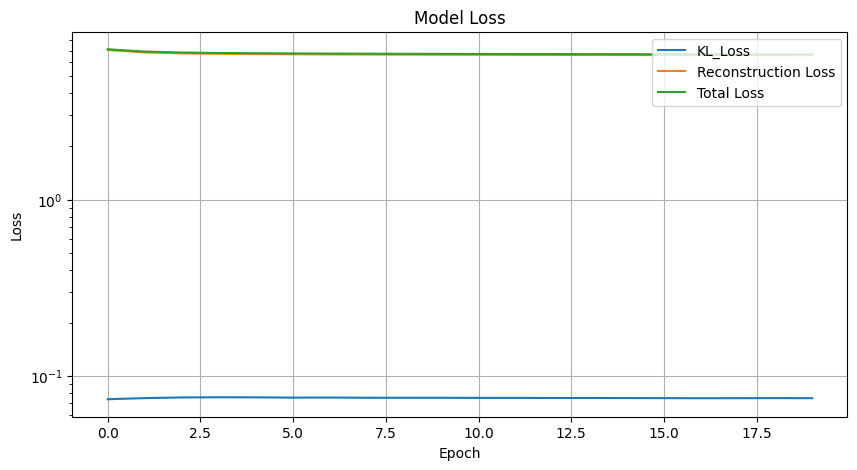

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['kl_loss'], label='KL_Loss')
plt.plot(hist.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(hist.history['loss'], label='Total Loss')
plt.yscale('log')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
model_name = "midpoint_VAE_beta_{}-ldim_{}-batch_size_{}".format(beta, latent_dim, batch_size)

vae.build(input_shape=train_data.shape[1:])

vae.save(model_name + '.keras')


In [ ]:
path_to_model = '../VAE/VAE_beta_1e-3-ldim_12-batch_size_384.keras'

vae = keras.models.load_model(path_to_model, custom_objects={'Sampling': Sampling})

vae.build(input_shape=train_data.shape[1:])

## Model assesment

#### Tracking a datapoint

In [13]:
write_it = False

samp = np.random.randint(0, n)
data_point = train_data[samp] 
latent_data = vae.encoder.predict(data_point.reshape(1, *data_point.shape))[0]
latent_data = latent_data.reshape(1, latent_dim, 1) 

latent_noised = latent_data + np.random.normal(loc = 0., scale = np.std(latent_data))

new_data_noised = vae.decoder.predict(latent_noised) 
new_data_noised = new_data_noised.reshape(fbands, twindow) 

new_data = vae.decoder.predict(latent_data) 
new_data = new_data.reshape(fbands, twindow) 

audio_noised = pipe_inv(new_data_noised, train_max, train_min) 
audio = pipe_inv(new_data, train_max, train_min) 
audio_original = pipe_inv(data_point, train_max, train_min)

original = Audio(audio_original, rate=SAMPLE_RATE) 
regenerated = Audio(audio, rate=SAMPLE_RATE) 
noised = Audio(audio_noised, rate=SAMPLE_RATE)

display(original)
display(regenerated)
display(noised)

if write_it:
        
    write('orig_mp2.wav', SAMPLE_RATE, audio_original)
    write('recon_mp2.wav', SAMPLE_RATE, audio)
    write('lat_noised_mp2.wav', SAMPLE_RATE, audio_noised)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [14]:
# adding noise to the sample

data_point = train_data[samp] + np.random.normal(loc=0., scale = 0.6*train_data[samp].mean(), size = train_data[samp].shape)
latent_data = vae.encoder.predict(data_point.reshape(1, *data_point.shape)) 
latent_data = latent_data[0] 
latent_data = latent_data.reshape(1, latent_dim, 1) 
new_data = vae.decoder.predict(latent_data) 
new_data = new_data.reshape(fbands, twindow) 
audio = pipe_inv(new_data, train_max, train_min) 
noised = pipe_inv(data_point, train_max, train_min)
original = Audio(noised, rate=SAMPLE_RATE) 
regenerated = Audio(audio, rate=SAMPLE_RATE) 

display(original)
display(regenerated)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [15]:
# feeding in an audio sample from the test set


wrd = 'no/'
word_dir = '../VAE/data/full_speech_commands/' + wrd
files = os.listdir(word_dir)
rand = np.random.randint(len(files))

path = word_dir + files[rand]

audio_sample, _ = librosa.load(path, sr = SAMPLE_RATE)

display(Audio(audio_sample, rate = SAMPLE_RATE))
log_spec = pre_pipe(audio_sample)
latent_mapping = vae.encoder.predict(log_spec.reshape((1,fbands, twindow, 1)))[0]
regen_spec = vae.decoder.predict(latent_mapping.reshape((1, latent_dim, 1))).reshape(fbands, twindow)
regen_audio = pipe_inv(regen_spec, train_max, train_min)
display(Audio(regen_audio, rate = SAMPLE_RATE))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


#### Mean of a label

In [16]:
word = 'yes'
lab = label2int[word] 
data_word = train_data[labs == lab] 
latent_data_word = vae.encoder.predict(data_word)[0] 

cluster_mean = np.mean(latent_data_word, axis=0)
cl_rep = cluster_mean.reshape(1, latent_dim, 1) 
    
regenerated_word = vae.decoder.predict(cl_rep) 
regenerated_word = regenerated_word.reshape(fbands, twindow) 
regenerated_audio = pipe_inv(regenerated_word, train_max, train_min) 
regenerated_Audio = Audio(regenerated_audio, rate=SAMPLE_RATE) 

display(regenerated_Audio)


# write('mean_yes_asym.wav', SAMPLE_RATE, regenerated_audio)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


#### latent space visualization

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


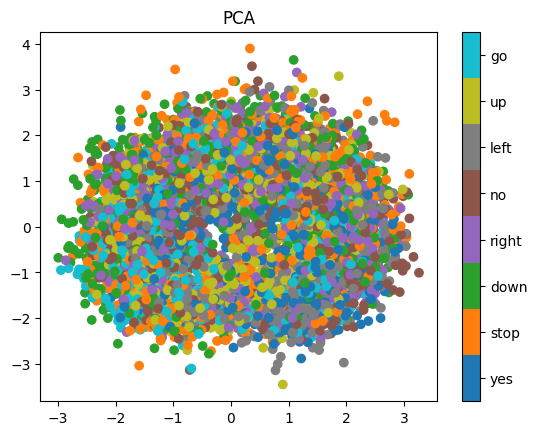

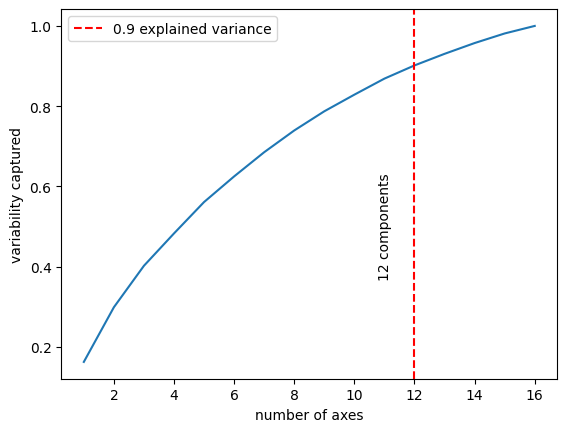

In [ ]:
pred = vae.encoder.predict(train_data)[0]

plot_PCA(pred, labs, n, ldim = latent_dim)

plot_tsne(pred, labs, n)

#### inspection of the clusters

In [ ]:
pred = vae.encoder.predict(train_data)[0]
n_clusters = len(allowed_words)*10
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(pred)

cluster_labels = gmm.predict(pred)

for cl in range(n_clusters):
    hist = np.histogram(labs[cluster_labels == cl], bins = np.arange(len(allowed_words)+1), density=True)[0]
    if np.sort(hist)[-1] > 0.75:
        cl_mean = pipe_inv(vae.decoder.predict(gmm.means_[cl].reshape(1,latent_dim,1)).reshape(fbands, twindow), train_max, train_min)
        display(Audio(cl_mean, rate=SAMPLE_RATE))
        num, bins, patches = plt.hist(labs[cluster_labels == cl], bins = np.arange(len(allowed_words)+1)-.5, density=True, color = '#606c38')
        plt.title('density of each word in cluster #'+str(cl))
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.xticks(bin_centers, allowed_words)
        plt.savefig('densities in cluster #'+str(cl))
        write('cluster #' + str(cl) + ' mean.wav', SAMPLE_RATE, cl_mean)
        
        plt.show()
